In [120]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [121]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')
df = df.drop(columns=['Director', 'Cast', 'Wiki Page'])
df.head(3)

,Release Year,Title,Origin/Ethnicity,Genre,Plot
0,1901,Kansas Saloon Smashers,American,unknown,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,unknown,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,unknown,"The film, just over a minute long, is composed..."


In [122]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r"[.,?!()\/#*&$^\-_:;'<>\[\]\"\\]", "", text)
    text = re.sub(r"(?<!\d)\d(?!\d)", "", text)
    text = text.lower()
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [123]:
import yake
number_of_important_words = 50
stop_words = set(stopwords.words('english'))

def get_important_words(plot):
    # Simple usage with default parameters
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(plot)

    keywords_sorted = sorted(keywords, key=lambda x: x[1], reverse=True)

    important_words = []

    for kw, score in keywords_sorted:
        split_list = kw.split(' ')
        for word in split_list:
            if word not in stop_words:
                important_words.append(word)
                if len(important_words) == number_of_important_words:
                    break

    return important_words



In [124]:
n = 1000
df_sample = df.head(n)

all_tokens = list(set(chain.from_iterable(df_sample['Plot'].apply(get_important_words))))
all_tokens.sort()

In [125]:
X = np.zeros((n, len(all_tokens)))


for i, text in enumerate(df_sample['Plot']):
    word_dict = {word: 0 for word in all_tokens}
    sample_entry = get_important_words(text)
    sample_dct = Counter(sample_entry)
    for word, count in sample_dct.items():
        word_dict[word] += count
    X[i] = list(word_dict.values())

In [126]:
X

X.shape


(1000, 7644)

In [127]:
pca = PCA()
pca.fit(X)


PCA()

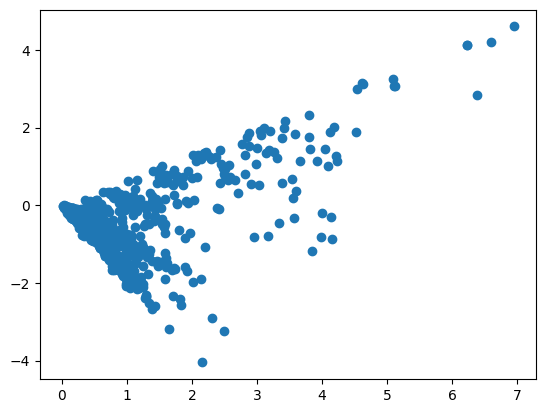

(1000, 2)

In [128]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)  # or 3
reduced = svd.fit_transform(X)
reduced

plt.scatter(reduced[:,0], reduced[:,1])
plt.show()
reduced.shape

C:\Users\Christian\AppData\Local\Temp\ipykernel_28372\4125315182.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced[:, 0], reduced[:, 1], c=mapped_colors, cmap='viridis')


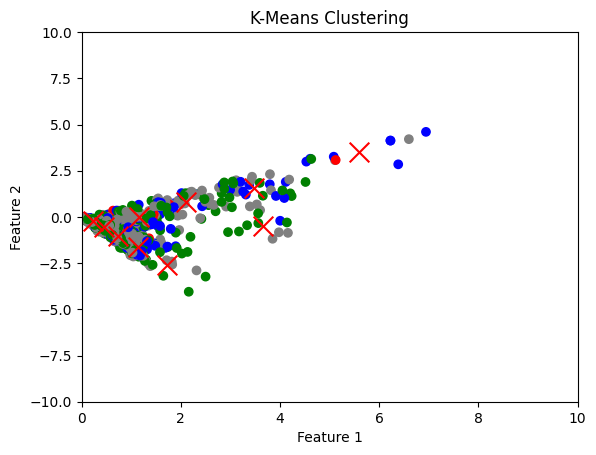

{'romance': 'red', 'comedy': 'blue', 'drama': 'green'}


In [129]:
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

# 2. Initialize the KMeans model
kmeans = KMeans(n_clusters=10, random_state=42)

# 3. Fit the model to your data
kmeans.fit(reduced)

# 4. Get cluster assignments
#labels = kmeans.labels_
labels = df_sample['Genre'].values
'''
genres = pd.unique(labels)
colors = plt.cm.tab10.colors
color_map = {g: colors[i % len(colors)] for i, g in enumerate(genres)}
mapped_colors = [mcolors.to_hex(color_map[g]) for g in labels]'''
color_map = {
    'romance': 'red',
    'comedy': 'blue',
    'drama': 'green'
}

default_color = 'gray'

mapped_colors = [mcolors.to_hex(color_map.get(g, default_color)) for g in labels]

# 5. Get cluster centers
centers = kmeans.cluster_centers_

plt.scatter(reduced[:, 0], reduced[:, 1], c=mapped_colors, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200)
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.axis([0, 10, -10, 10])
plt.show()

print(color_map)

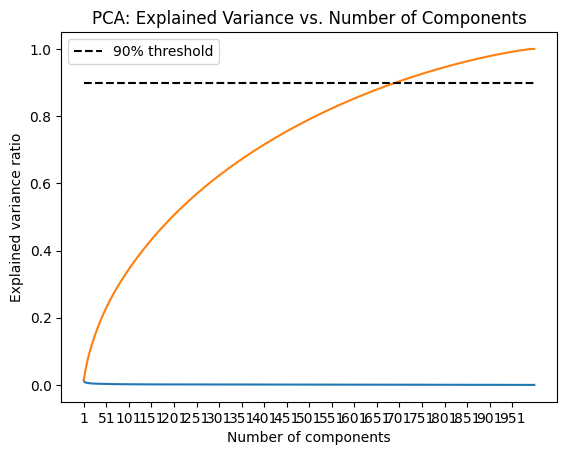

Number of components required to reach 90% explained variance: 693


In [130]:
threshold = 0.9

# Determine how many components are needed to reach the threshold
required_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1

# Plot the accumulated explained variance ratio
fig = plt.figure()
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_)
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_))
plt.plot([1, 1+pca.n_components_], [threshold, threshold], "k--", label=f"{threshold:.0%} threshold")
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.xticks(range(1, pca.n_components_+1)[::50])
plt.legend()
plt.show()

### END SOLUTION
print(f"Number of components required to reach {threshold:.0%} explained variance: {required_components}")

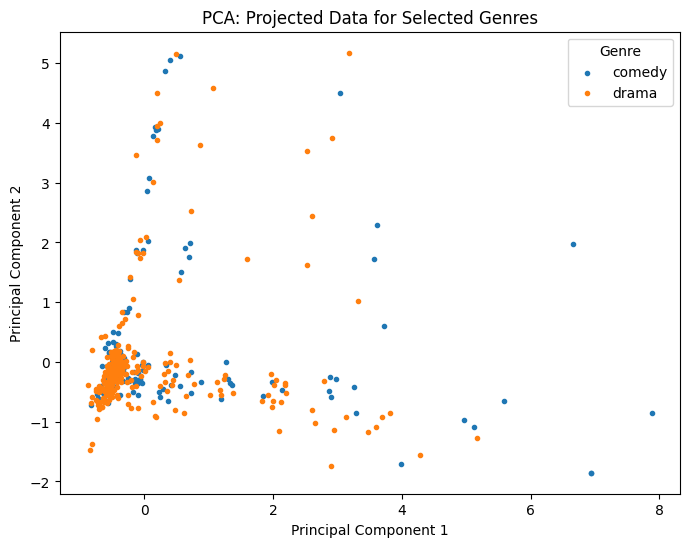

In [131]:

# Pick genres to visualize
genres = ['comedy', 'drama']

# Compute PCA projection if not already done
B = pca.transform(X)
# (or skip this if B is already computed)

plt.figure(figsize=(8, 6))

for genre in genres:
    mask = (df_sample['Genre'] == genre)
    plt.scatter(B[mask, 0], B[mask, 1], marker='.', label=genre)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: Projected Data for Selected Genres")
plt.legend(title="Genre")
plt.show()

In [132]:
df_sample['Genre'].value_counts()

Genre
drama                 313
comedy                209
unknown                58
western                37
adventure              33
                     ... 
period drama            1
comedy western          1
fantasy, family         1
fantasy, adventure      1
prison drama            1
Name: count, Length: 82, dtype: int64

In [133]:
len(df_sample)


pca = PCA(n_components=2)
C = pca.fit_transform(X)

print(C.shape)

C = B



(1000, 2)


C:\Users\Christian\AppData\Local\Temp\ipykernel_28372\97345033.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(C[:, 0], C[:, 1], c=mapped_colors, cmap='viridis')


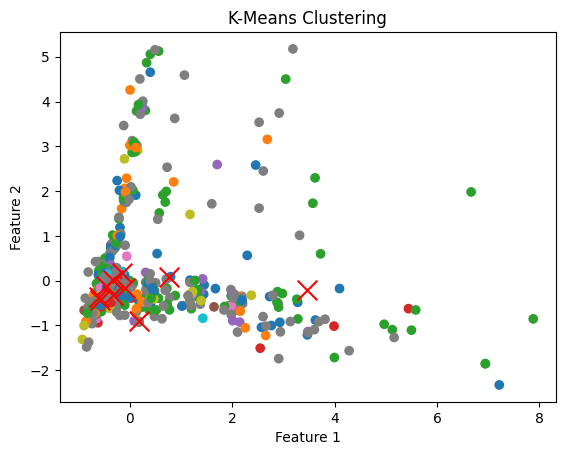

In [134]:
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

# 2. Initialize the KMeans model
kmeans = KMeans(n_clusters=10, random_state=42)

# 3. Fit the model to your data
kmeans.fit(C)

# 4. Get cluster assignments
#labels = kmeans.labels_
labels = df_sample['Genre'].values
genres = pd.unique(labels)
colors = plt.cm.tab10.colors
color_map = {g: colors[i % len(colors)] for i, g in enumerate(genres)}
mapped_colors = [mcolors.to_hex(color_map[g]) for g in labels]

# 5. Get cluster centers
centers = kmeans.cluster_centers_

plt.scatter(C[:, 0], C[:, 1], c=mapped_colors, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200)
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

#plt.axis([0, 20, 0, 20])
plt.show()